In [2]:
import datetime, time
import numpy as np
import pandas as pd
import csv, os
from scipy import stats
from matplotlib import pyplot as plt

import generate_dose_response as gdr
import BMD_BMDL_estimation as bmdest
import Plot_Save as ps
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
os.getcwd()

complete_file_path = '/Users/kimd999/Dropbox/script/python/toxicology/DN_try/Phase_I_II.csv'

morphological_data = pd.read_csv(complete_file_path, header = 0)
display(morphological_data.head())
display(morphological_data.columns)
display(np.unique(morphological_data.well))

'''
### clear existing result csv files.
if (os.path.isfile("bmd_vals.csv") == True):
    os.remove("bmd_vals.csv")
if (os.path.isfile("fit_vals.csv") == True):
    os.remove("fit_vals.csv")
if (os.path.isfile("dose_response_vals.csv") == True):
    os.remove("dose_response_vals.csv")
    '''

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRAI,CFIN,CIRC,DNC_,...,PE__,PFIN,PIG_,SM24,SNOU,SOMI,SWIM,TRUN,TR__,YSE_
0,53,9289,A01,53_9289_A01,50.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,53,9289,A02,53_9289_A02,35.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,9289,A03,53_9289_A03,11.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,9289,A04,53_9289_A04,5.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,53,9289,A05,53_9289_A05,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['chemical.id', 'plate.id', 'well', 'chemical_plate_well', 'conc',
       'AXIS', 'BRAI', 'CFIN', 'CIRC', 'DNC_', 'DP24', 'EYE_', 'JAW_', 'MO24',
       'MORT', 'NC24', 'NC__', 'OTIC', 'PE__', 'PFIN', 'PIG_', 'SM24', 'SNOU',
       'SOMI', 'SWIM', 'TRUN', 'TR__', 'YSE_'],
      dtype='object')

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A11', 'A12', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'C01', 'C02', 'C03',
       'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12',
       'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09',
       'D10', 'D11', 'D12', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06',
       'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'F01', 'F02', 'F03',
       'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12',
       'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09',
       'G10', 'G11', 'G12', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12'], dtype=object)

'\n### clear existing result csv files.\nif (os.path.isfile("bmd_vals.csv") == True):\n    os.remove("bmd_vals.csv")\nif (os.path.isfile("fit_vals.csv") == True):\n    os.remove("fit_vals.csv")\nif (os.path.isfile("dose_response_vals.csv") == True):\n    os.remove("dose_response_vals.csv")\n    '

In [31]:
test_data_sim = 0
if(test_data_sim == 0):
    # Add aggregate endpoints
    # 1. Any effect at 24hrs (combination of MO24, DP24 and SM24) >> 'ANY24'
    # 2. Any effect within 5 days (combination of all measurements at both time points)
    # 3. Total mortality (MO24 + MORT) >> 'TOT_MORT'
    # 4. Any effect except mortality (#2 minus MO24 and MORT) >> 'ANY_MORT'
    # Add new endpoints
    # BRAIN	OTIC	PFIN >> 'BRN_'
    # EYE	SNOUT	JAW >> 'CRAN'
    # YSE	PE >> 'EDEM'
    # TRUNK	CFIN >> 'LTRK'
    # CIRC	SWIM	SOMITE >> 'MUSC'
    # PIG_ >> 'SKIN'
    # TR_ >> 'TCHR'
    morphological_data['ANY24'] = morphological_data[['MO24','DP24','SM24','NC24']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['ANY120'] = morphological_data[['MORT', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', \
                                                       'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC', \
                                                       'TRUN', 'SWIM', 'NC__', 'TR__', 'DNC_', 'ANY24']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['TOT_MORT'] = morphological_data[['MO24','MORT']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['ANY_MORT'] = morphological_data[['DP24','SM24','NC24', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', \
                                                       'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC','TRUN', 'SWIM', 'NC__', \
                                                       'TR__', 'DNC_']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['BRN_'] = morphological_data[['BRAI','OTIC','PFIN']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['CRAN'] = morphological_data[['EYE_', 'SNOU', 'JAW_']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['EDEM'] = morphological_data[['YSE_','PE__']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['LTKR'] = morphological_data[['TRUN','CFIN']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['MUSC'] = morphological_data[['CIRC','SWIM','SOMI']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['SKIN'] = morphological_data[['PIG_']]
    morphological_data['TCHR'] = morphological_data[['TR__']]

In [34]:
today = datetime.datetime.today()
date_based_working_folder = today.strftime('%Y%m%d') + "_" + str(today.hour) \
                            + "_" + str(today.minute) + "_" + str(today.second)
output_folder = os.path.join("output", date_based_working_folder)
output_folder_abs_path = os.path.abspath(output_folder)
print ("output_folder_abs_path:" + str(output_folder_abs_path))
if (os.path.isdir(output_folder_abs_path) == False):
    os.mkdir(output_folder_abs_path)

output_folder_abs_path:/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/dn_edit/output/20201027_18_18_9


In [35]:
start_time = time.time()

print ("output_folder_abs_path:" + str(output_folder_abs_path))
# Specify end_point and chemical of interest
# *********************************************
# Perform a check of the existence of "essential" column labels
# *********************************************
qc_flag_filename = os.path.join(output_folder_abs_path, 'qc_flag.csv')
f_out_qc_flag = open(qc_flag_filename, "w")
write_this = "qc_flag\n"
f_out_qc_flag.write(write_this)

array_filename = os.path.join(output_folder_abs_path, 'array_report.csv')
f_out = open(array_filename, "w")
write_this = "chemical_id,end_point,len_test_dose_response\n"
f_out.write(write_this)

#dictio={}

# full -> 18
end_points = ['ANY24','ANY120','AXIS','ANY_MORT','BRN_','CRAN','DP24','EDEM','LTKR','MO24','MORT','MUSC','NC__','NC24', 'SKIN','SM24','TCHR','TOT_MORT']
    
#end_points = ['ANY24','ANY120','TOT_MORT','ANY_MORT','BRN_','CRAN','EDEM','LTKR','MUSC','SKIN','TCHR']
#end_points = ['AXIS','NC__','MO24','DP24','SM24','MORT']
#end_points = ['NC24']
for chemical_id in np.unique(morphological_data['chemical.id']):
#for chemical_id in [54]:
#for chemical_id in [53, 54]:
#    print(chemical_id)
    for end_point in end_points:
        # subset original dataframe for a user-specified chemical and end_point pair
        morphological_data_end_point_chemical_id = morphological_data.loc[morphological_data['chemical.id'] == chemical_id,['chemical.id', 'conc', 'plate.id', 'well', end_point]]

        # Binarize end-point hits (Values > 1 are forced to 1)
        end_point_hits = morphological_data_end_point_chemical_id[end_point]
        end_point_hits.loc[end_point_hits > 0] = 1

        dose_response = gdr.gen_dose_response(morphological_data_end_point_chemical_id, end_point)
        qc_flag = gdr.BMD_feasibility_analysis(dose_response)
        f_out_qc_flag.write(str(qc_flag)+"\n")

#        test_dose_response = gdr.reformat_dose_response(dose_response)
#        dictio[str(chemical_id), str(end_point)] = str(len(test_dose_response))
#        write_this = str(chemical_id) + "," + str(end_point) + "," + str(len(test_dose_response)) + "\n"
 #       print ("write_this:"+str(write_this))
  #      f_out.write(write_this)
        #array_report.append((str(chemical_id), str(end_point), str(len(test_dose_response))))
        #if(qc_flag in [0, 1]):
#        if(qc_flag in []):
#            # No BMD analysis required. Generate report and exit
#            print ("qc_flag in [0]")
#            ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, output_folder_abs_path, None)
            #ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, None)
 #           '''
  #      else:
        if(qc_flag in [2]):
            # Fit dose response models
            model_predictions = bmdest.analyze_dose_response_data(test_dose_response)
            # Select best model
            selected_model_params = bmdest.select_model(model_predictions)
            # Check if unique model is found
            unique_model_flag = selected_model_params['no_unique_model_found_flag']
            if(unique_model_flag == 0):
                # Generate report
                print(test_dose_response.dose[-1:])
                ps.save_results_good_data_unique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), output_folder_abs_path, end_point)
                #ps.save_results_good_data_unique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
            else:
                bmd_analysis_flag = selected_model_params['model_select_flag']
                if(bmd_analysis_flag == 1):
                    print ("bmd_analysis_flag = 1")
                    exit(1)
                    #ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, output_folder_abs_path, selected_model_params)
                else:
                    print ("save_results_good_data_nounique_model")
                    exit(1)
                    ps.save_results_good_data_nounique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), output_folder_abs_path, end_point)
f_out.close()
f_out_qc_flag.close()
#np.savetxt(array_filename, array_report, delimiter=',', fmt = '%s')

#dict_csv_filename = os.path.join(output_folder_abs_path, 'dictio.csv')
#with open(dict_csv_filename, 'w') as f:
#    for key in dictio.keys():
#        f.write("%s,%s\n"%(key,dictio[key]))


end_time = time.time()
time_took = str(round((end_time-start_time), 1)) + " seconds "
print ("time_took:"+str(time_took))

output_folder_abs_path:/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/dn_edit/output/20201027_18_18_9
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 32
         Function evaluations: 100
logistic
-1.4675105125884815
-1.532592313040554
Estimating BMDL ...
weibull
6.658728983457056e+39
7.665762956672279e+43
Estimating BMDL ...
[ 1.00000000e-05 -1.49316614e+01  5.18033862e-01]
log_logistic
47417058839.05264
3295954467255.2236
Estimating BMDL ...
5    5.0
Name: dose, dtype: float64
46
46
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 32
         Function evaluations: 100
logistic
-1.4675105125884815
-1.532592313040554
Estimating BMDL ...
weibull
6.658728983457056e+39
7.665762956672279e+43
Estimating BMDL ...
[ 1.00000000e-05 -1.49316614e+01  5.18033862e-01]
log_logistic
47417058839.05264
3295954467255.2236
Estimating BMDL ...
5    5.0
Name: dose, dtype: float64
46
46
Op

qc_flag_filename:/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/dn_edit/output/20201027_17_12_22/qc_flag.csv


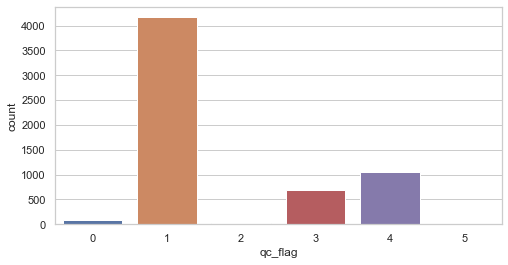

In [27]:
print ("qc_flag_filename:"+str(qc_flag_filename))
qc_flag_data = pd.read_csv(qc_flag_filename, index_col=None)
#display(qc_flag_data.head())
ds = pd.Series({"Column": qc_flag_data["qc_flag"]})
plt.figure(figsize=(8,4))
sns.countplot(x="Column", data=ds)
plt.show()


array_filename:/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/dn_edit/output/20201027_17_6_55/array_report.csv


,chemical_id,end_point,len_test_dose_response
0,54,NC24,6


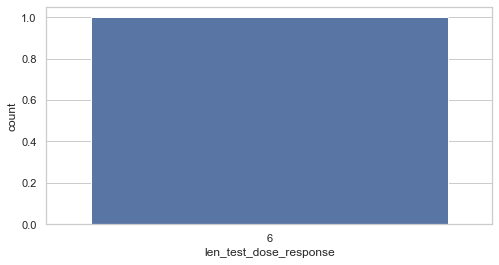

done


<Figure size 432x288 with 0 Axes>

In [7]:
'''
# saved working code
# works great
sns.set_theme(style="whitegrid")
print ("array_filename:"+str(array_filename))
array_report_data = pd.read_csv(array_filename, index_col=None)
display(array_report_data.head())
#ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)

ds = pd.Series({"Column": array_report_data["len_test_dose_response"]})
plt.figure(figsize=(8,4))
sns.countplot(x="Column", data=ds)
plt.show()
print ("done")
'''

array_filename:/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/dn_edit/output/20201027_17_6_55/array_report.csv


,chemical_id,end_point,len_test_dose_response
0,54,NC24,6


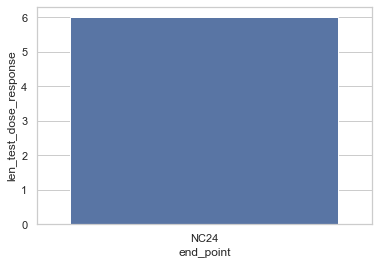

In [8]:
'''
# saved working code
# works well, just too many endpoints in x-axis superimpose each other
sns.set_theme(style="whitegrid")
print ("array_filename:"+str(array_filename))
array_report_data = pd.read_csv(array_filename, index_col=None)
display(array_report_data.head())
ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)
'''

In [9]:
display(morphological_data.head())
morphological_data.columns

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRAI,CFIN,CIRC,DNC_,...,ANY120,TOT_MORT,ANY_MORT,BRN_,CRAN,EDEM,LTKR,MUSC,SKIN,TCHR
0,53,9289,A01,53_9289_A01,50.0,NaN,NaN,NaN,NaN,0.0,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53,9289,A02,53_9289_A02,35.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,9289,A03,53_9289_A03,11.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,9289,A04,53_9289_A04,5.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
4,53,9289,A05,53_9289_A05,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['chemical.id', 'plate.id', 'well', 'chemical_plate_well', 'conc',
       'AXIS', 'BRAI', 'CFIN', 'CIRC', 'DNC_', 'DP24', 'EYE_', 'JAW_', 'MO24',
       'MORT', 'NC24', 'NC__', 'OTIC', 'PE__', 'PFIN', 'PIG_', 'SM24', 'SNOU',
       'SOMI', 'SWIM', 'TRUN', 'TR__', 'YSE_', 'ANY24', 'ANY120', 'TOT_MORT',
       'ANY_MORT', 'BRN_', 'CRAN', 'EDEM', 'LTKR', 'MUSC', 'SKIN', 'TCHR'],
      dtype='object')

In [10]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
display(tips.head())
#ax = sns.barplot(x="day", y="total_bill", data=tips)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [11]:
test_dose_response.dose

0    0.00
1    0.10
2    0.50
3    1.12
4    3.56
5    5.00
Name: dose, dtype: float64

In [12]:
test_dose_response.dose.iloc[0]+test_dose_response.dose.iloc[1]

0.1

In [13]:
dose_response['num_affect']/dose_response['num_embryos']

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
dtype: float64